In [1]:
%load_ext autoreload
%autoreload 2

#%load_ext memory_profiler
#%load_ext line_profiler

In [6]:
from __future__ import print_function
import IPython
import pickle
#
import os, sys, math
import pandas as pd
import time
import numpy as np
#import pandas as pd
import sklearn as skl
import statistics
from sklearn.neighbors import NearestNeighbors, DistanceMetric
#from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import scipy.special as sp
#
import eknn
from wrap import *

#pretty plots if seaborn is installed
try: 
    import seaborn as sns
    sns.set(style='ticks', palette='Set2',font_scale=1.5)
    #sns.set() 
except:
    pass

%matplotlib inline

# Planck Chains analysis

In [40]:
chain_dir='chains/base_planck_lowl_lowLike_post_lensing'
chain_root='base_planck_lowl_lowLike_post_lensing'
chain_path=os.path.join(chain_dir,chain_root)

from getdist import loadMCSamples
samples = loadMCSamples(chain_path, settings={'ignore_rows':0.2})

ncorr=max(1,int(samples.getCorrelationLength(3)))
print('Samples are thinned by the correlation length of ',ncorr)

npar=6
planck_chain={}
planck_chain['samples']=samples.samples[:,0:npar]
planck_chain['lnprob']=-samples.loglikes
planck_chain['weight']=samples.weights

Samples are thinned by the correlation length of  1


In [9]:
#samples.getNumSampleSummaryText()
x=samples.getParamNames()
#x.list()

In [21]:
print(planck_chain['lnprob'].min(),planck_chain['lnprob'].max())

-4936.561 -4909.465


In [41]:
chain_dir='chains/base_planck_lowl_lowLike_post_lensing'
chain_root='base_planck_lowl_lowLike_post_lensing'
chain_path=os.path.join(chain_dir,chain_root)

#pass burn-in parameter ignore_rows to getdist (0.3 ignores first 30% of lines)
gdkwargs = {'settings':{"ignore_rows":0.2}}

#
eplanck=eknn.echain(method=chain_path,verbose=2,ischain=True,gdkwarg=gdkwargs)
MLE=eplanck.chains2evidence(unitvar=True,thin=False) 


Using chains:  chains/base_planck_lowl_lowLike_post_lensing/base_planck_lowl_lowLike_post_lensing
chain array dimensions: 14282 x 6 =
k=1,nsample=14282, dotp=8.29596151147e-13, median_volume=1.36738293532e-17, a_max=5.80827663059e-17, MLE=-4932.89397606
k=2,nsample=14282, dotp=2.27651751376e-12, median_volume=4.11758046404e-17, a_max=7.96960445917e-17, MLE=-4932.57762511
k=3,nsample=14282, dotp=3.82943022295e-12, median_volume=7.37395455865e-17, a_max=8.93745238395e-17, MLE=-4932.46300939
k=4,nsample=14282, dotp=5.94547022711e-12, median_volume=1.097292303e-16, a_max=1.04070966184e-16, MLE=-4932.31077203

MLE[k=(1,2,3,4)] =  [-4932.89397606 -4932.57762511 -4932.46300939 -4932.31077203]



In [33]:
print(planck_chain['lnprob'].min(),planck_chain['lnprob'].max())

-27.096 0.0


## PyStan example

In [3]:
import pystan

# First we will write our Baysian model using
# Stan code. 
# We will then define our data and call pystan 
# to do MCMC sampling using NUT sampler
# 
mvgauss_code="""
data {
  int<lower=1> N;
  vector[N] v;
  vector[N] y;
}
parameters {
  vector[N] mu; 
}
transformed parameters {  
  cov_matrix[N] Sigma;
  for (i in 1:N) 
    for (j in 1:N)
      Sigma[i,j] <- 0 + if_else(i==j, v[i], 0.0);
}
model {
  increment_log_prob(multi_normal_log(y,mu,Sigma));
  // y ~ multi_normal(mu,Sigma); //drops constants
}
"""

# Define data model: we will use 10-dimensional Gaussian
# as given in the alan_eg
dmv=eknn.alan_eg()
mvgauss_dat={'y':dmv.mean_sample,
             'v':dmv.sigma_mean**2,
             'N':dmv.ndim}

#file name where to save/read chain
cache_falan='chains/alan_pystan_chain.pkl'

#read chain from cache if possible 
try:
    #raise
    print('reading chain from: '+cache_falan)
    alan_stan_chain = pickle.load(open(cache_falan, 'rb'))
except:
    # Get pystan chain-- this will convert our pystan code into C++
    # and run MCMC
    if alan_fit in locals():
        #faster as we don't need C++ compiling
        alan_fit = pystan.stan(fit=alan_fit, data=mvgauss_dat, 
                               iter=100000, chains=4)     
    else:
        alan_fit = pystan.stan(model_code=mvgauss_code, data=mvgauss_dat,
                      iter=100000, chains=4)    
    

    # Extract PyStan chain for Harry's GLM example
    alan_stan_chain=alan_fit.extract(permuted=True)   
    print('writing chain in: '+cache_falan)
    with open(cache_falan, 'wb') as f:
            pickle.dump(alan_stan_chain, f)
            
if 'mu' in alan_stan_chain.keys(): alan_stan_chain['samples']=alan_stan_chain.pop('mu')
if 'lp__' in alan_stan_chain.keys(): alan_stan_chain['lnprob']=alan_stan_chain.pop('lp__')
    
print('chain shape: ',alan_stan_chain['samples'].shape)


mean_sample= [ 1.00663804  2.0050401   2.99678545  4.00222838  5.00092226  5.99705719
  7.002348    8.00165807  8.9958802   9.99522201]
std_sample= [ 1.00291056  1.00251878  0.99810422  1.00145269  1.00361784  0.99945399
  1.00485598  1.00191514  0.99895308  0.99432098]

reading chain from: chains/alan_pystan_chain.pkl
chain shape:  (200000, 10)


In [4]:
#
gdstans=samples2gdist(alan_stan_chain['samples'],alan_stan_chain['lnprob'],
                     trueval=dmv.mean,px='m')
#gdstans.corner()

dictionary of samples and loglike array passed
chain array dimensions: 200000 x 10 =
time profiling scikit knn ..
Thinning samples ..
Samples are thinned by the correlation length of  1
Chain length before and after thinning:  1000 1000
(iter,mean,min,max) of LogLikelihood:  0 43.4231889235 29.5035782683 47.4436337019
-------------------- useful intermediate parameter values ------- 
nsample, dotp, median volume, amax, MLE
1000 4 5.59541503621 5.24469216192e-22 0.00139850413302 1.39850413302
Thinning samples ..
Samples are thinned by the correlation length of  1
Chain length before and after thinning:  1128 1128
1128 4 5.42799435888 4.53927916507e-22 0.00120274636802 1.35669790313
Thinning samples ..
Samples are thinned by the correlation length of  1
Chain length before and after thinning:  1274 1274
1274 4 5.39316218534 4.11434245893e-22 0.00105810519626 1.34802602004
Thinning samples ..
Samples are thinned by the correlation length of  1
Chain length before and after thinning:  1438

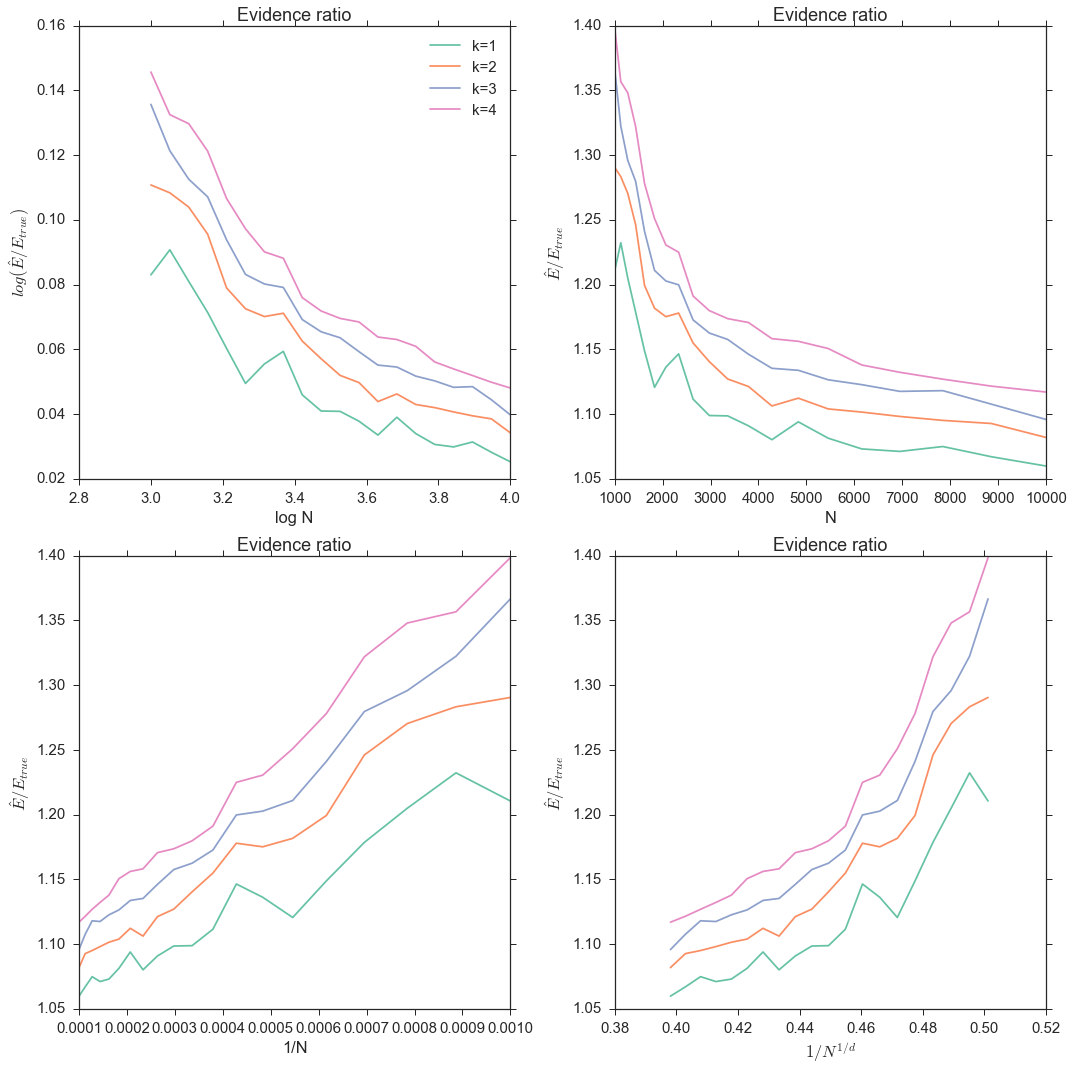

In [13]:
# Here given pystan samples and log probability, we compute evidence ratio 
ealan=eknn.echain(method=alan_stan_chain,verbose=2,ischain=True,brange=[3,4])
MLE,ptime=ealan.chains2evidence(rand=True,profile=True) 
ealan.vis_mle(MLE)

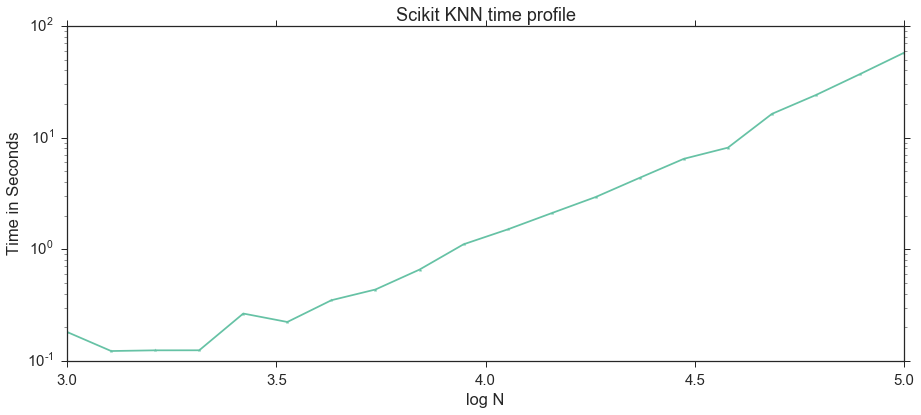

In [7]:
# plot KNN timing profile
fig,ax=plt.subplots(figsize=(15,6))
plt.semilogy(np.log10(ptime[:,0]),ptime[:,1],'-*',markersize=4) #,markercolor='r')
plt.xlabel('log N')
plt.ylabel('Time in Seconds')
plt.title('Scikit KNN time profile')
#plt.legend(['k=%s'%k for k in range(1,kmax+1)])

In [20]:
#help(NearestNeighbors.kneighbors)
10.0**5.2

158489.3192461114

### Pystan harry example 

In [9]:
import bayesglm as sglm
import pystan

harry_stanmodel='''
 data {
         int<lower=1> K;
         int<lower=0> N;
         real y[N];
         matrix[N,K] x;
 }
 parameters {
         vector[K] beta;
         real sigma;
 }
 model {         
         real mu[N];
         vector[N] eta   ;
         eta <- x*beta;
         for (i in 1:N) {
            mu[i] <- (eta[i]);
         };
         increment_log_prob(normal_log(y,mu,sigma));

 }
 '''   
harry=eknn.harry_eg()
df=pd.DataFrame()
df['x1']=harry.x
df['x2']=harry.x**2
df['y']=harry.y_sample

harry_data={'N':harry.ndata,
           'K':harry.ndim,
            'x':df[['x1','x2']],
           'y':harry.y_sample}
# Intialize pystan -- this will convert our pystan code into C++
# and run MCMC
#harry_fit = pystan.stan(model_code=harry_stanmodel, data=harry_data,
#                  iter=1000, chains=4)

In [10]:
iterations=10000
class jeffry_prior():
    def __init__(self, sigma):
        self.sigma = sigma

    def __repr__(self):
        return self.to_string()

    def to_string(self):
        return "normal(0,{0})".format(self.sigma)
class normal_prior():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __repr__(self):
        return self.to_string()

    def to_string(self):
        return "normal({0},{1})".format(self.mu, self.sigma)


#priors=(((i+1,), jeffry_prior(np.sqrt(harry.ndata))) for i in range(harry.ndim-1) )

priors={"x%s"%(i+1) : normal_prior(harry.theta[i+1],0.2) for i in range(harry.ndim-1) }

cache_fn='chains/harry_pystan_chain.pkl'
#read chain from cache if possible 
try:
    raise
    print('reading chain from: '+cache_fn)
    harry_stan_chain = pickle.load(open(cache_fn, 'rb'))
except:
    harry_fit = sglm.stan_glm("y ~ x1 + x2", df, 
                              family=sglm.family.gaussian(), 
                              iterations=iterations) #,priors=priors

    # Extract PyStan chain for Harry's GLM example
    harry_stan_chain=harry_fit.extract(permuted=True)   
    print('writing chain in: '+cache_fn)
    with open(cache_fn, 'wb') as f:
            pickle.dump(harry_stan_chain, f)

    #print stan model
    harry_model=harry_fit.stanmodel.model_code.expandtabs() #.rsplit('\n') 
    with open('harry.stan', 'w') as f:   
        f.write(harry_model[:])

theta_means = harry_stan_chain['beta'].mean(axis=0)
print('estimated: ',theta_means)
print('input: ',harry.theta)

#np.testing.assert_allclose(theta_means, harry.theta, atol=.01)

Using cached StanModel
writing chain in: chains/harry_pystan_chain.pkl
estimated:  [ 0.98950642  3.99970348 -0.99777075]
input:  [ 1.  4. -1.]


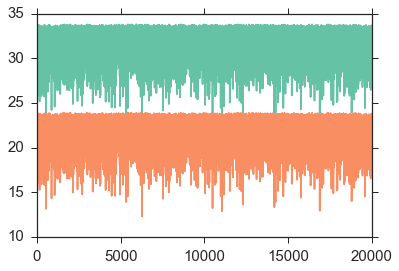

In [27]:
plt.plot(harry_stan_chain['lnprob'])
harry_stan_chain['lnprob']=harry_stan_chain['lnprob']+2*np.log(0.1/np.sqrt(1.0*harry.ndata))
plt.plot(harry_stan_chain['lnprob'])

(20000, 3)


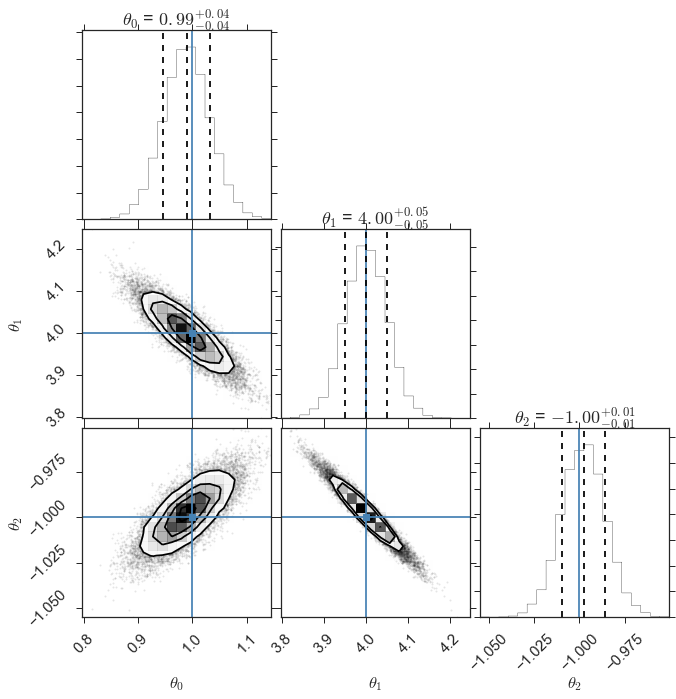

In [11]:
# Check input parameter recovery and estimate evidence
if 'beta' in harry_stan_chain.keys(): harry_stan_chain['samples']=harry_stan_chain.pop('beta')
if 'lp__' in harry_stan_chain.keys(): harry_stan_chain['lnprob']=harry_stan_chain.pop('lp__')
print(harry_stan_chain['samples'].shape)

#
gdstans=samples2gdist(harry_stan_chain['samples'],harry_stan_chain['lnprob'],
                     trueval=harry.theta,px='\\theta')
gdstans.corner(figsize=(10,10))
#gdstans.labels

dictionary of samples and loglike array passed
chain array dimensions: 20000 x 3 =
(iter,mean,min,max) of LogLikelihood:  0 32.8908663344 25.5566195966 34.8639144733
-------------------- useful intermediate parameter values ------- 
nsample, dotp, median volume, amax, MLE
1000 4 148418786214.0 3.8561229552e-07 37095422.6979 37095422697.9
1128 4 144170077229.0 3.27894469042e-07 31945507.9168 36034532930.2
1274 4 141514564424.0 2.83934370109e-07 27764285.7414 35371700034.6
1438 4 138417296101.0 2.50193825918e-07 24060020.1809 34598309020.2
1623 4 134610254410.0 2.12181395907e-07 20731596.2436 33647380703.3
1832 4 127538430603.0 1.85880511986e-07 17401887.1064 31880257179.0
2069 4 125544499362.0 1.63642620161e-07 15167874.7568 31382332871.9
2335 4 125435977272.0 1.51417187349e-07 13428538.4083 31355637183.5
2636 4 125262727158.0 1.3110267405e-07 11878874.0786 31312712071.1
2976 4 120866689007.0 1.14432409682e-07 10152598.8246 30214134102.0
3359 4 118750357556.0 1.02014232888e-07 8837564.7

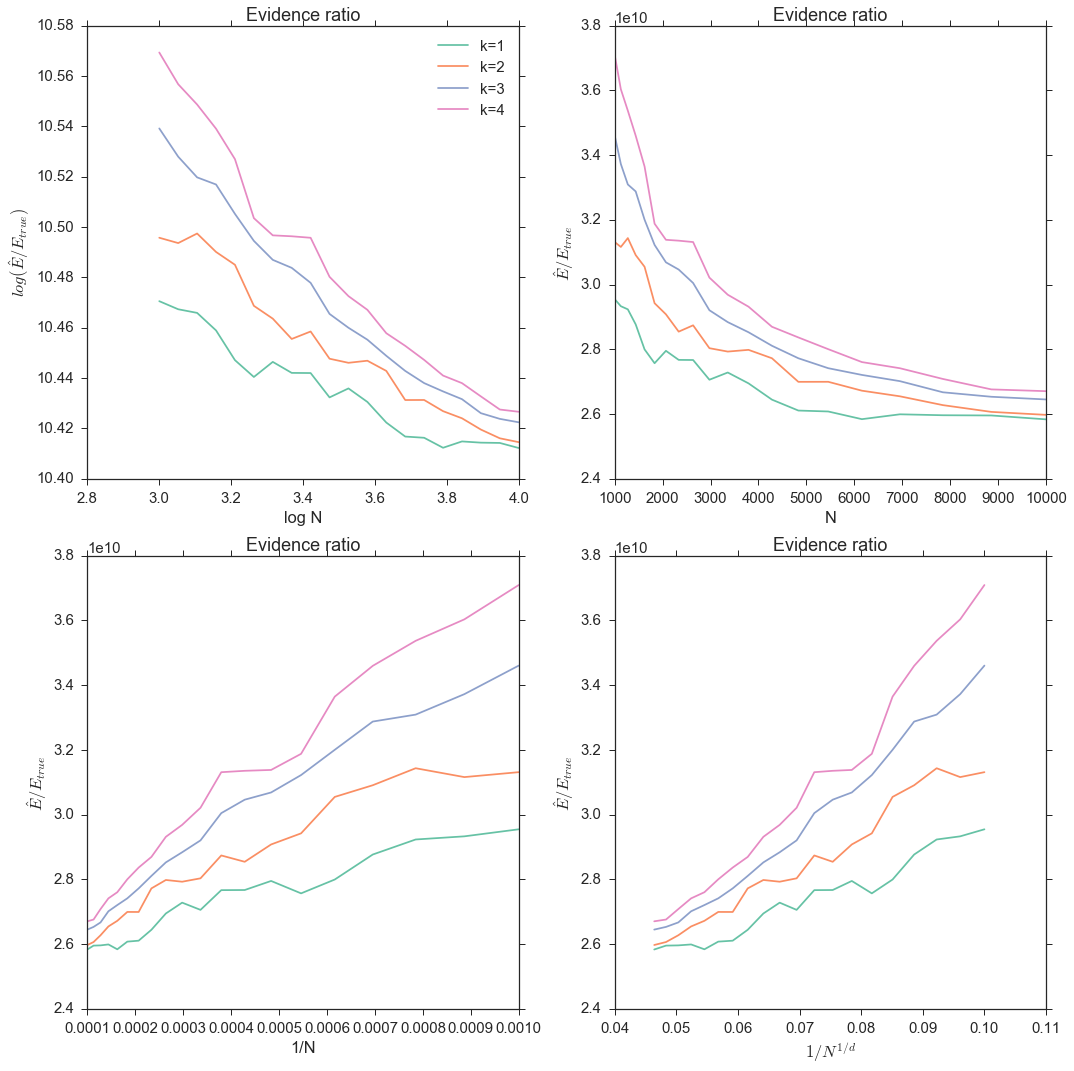

In [13]:
# Here given pystan samples and log probability, we compute evidence ratio 
eharry=eknn.echain(method=harry_stan_chain,verbose=2,ischain=True,brange=[3,4])
MLE=eharry.chains2evidence() 
eharry.vis_mle(MLE)

## Emcee example

In [164]:
##learn about emcee sampler using help
#help(mec2d.sampler)

## emcee sampling using N-dimensional Gaussian likelihood

In [12]:
#
#gd_mc.samples.getName()
help(gd.MCSamples.getCorrelationLength)

Help on method getCorrelationLength in module getdist.chains:

getCorrelationLength(self, j, weight_units=True, min_corr=0.05, corr=None) unbound getdist.mcsamples.MCSamples method
    Gets the auto-correlation length for parameter j
    
    :param j: The index of the parameter to use
    :param weight_units: False to get result in sample point (row) units; weight_units=False gives standard definition for raw chains
    :param min_corr: specifies a minimum value of the autocorrelation to use, e.g. where sampling noise is typically as large as the calculation
    :param corr: The auto-correlation array to use, calculated internally by default using :func:`getAutocorrelation`
    :return: the auto-correlation length



In [8]:
#Evidence calculation based on emcee sampling
mNd=eknn.alan_eg()
mecNd=make_emcee_chain(mNd,nwalkers=300)
samples,lnp=mecNd.mcmc(nmcmc=50000,thin=50)


mean_sample= [  1.00124961   2.0009409    2.99908074   3.99953955   5.00190023
   6.00045996   6.99611835   8.00040727   9.00038253  10.00286127]
std_sample= [ 1.00043959  1.00147762  1.0047039   0.99977695  0.9998301   0.99975875
  0.9972775   0.99908501  0.9978077   1.00014945]

instance of a model class is passed
emcee: Exception while calling your likelihood function:
  params: [ 1.00449673  1.99390132  3.00108253  3.99622691  5.00202134  6.00145256
  6.9889065   7.99508738  9.00039809  9.99070562]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/yabebal/anaconda/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "eknn.py", line 298, in lnprob
    np.sum(np.log(self.sigma_mean)))
  File "/Users/yabebal/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 1814, in sum
    out=out, **kwargs)
  File "/Users/yabebal/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py", line 32, in _sum
    return umr_sum(a, axis, dtype, out, keepdims)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
#corner plot can be done also using getdist wrapper
#getdist wrapper has a lot more functionality than just plotting
gd_mc=samples2gdist(samples,lnp,trueval=mNd.mean,px='m')
print('correlation length:',gd_mc.samples.getCorrelationLength(3))
gd_mc.samples.thin(20)
##gd_mc.corner()
#mecNd.emcee_sampler.get_autocorr_time(fast=True)

In [28]:
thin_samples=gd_mc.samples.samples
thin_lnp=gd_mc.samples.loglikes

print(len(thin_lnp),thin_samples.shape)

#estimate evidence
ealan=eknn.echain(method={'samples':thin_samples,'lnprob':thin_lnp},
                  verbose=2,ischain=True,brange=[3,4.2])
MLE=ealan.chains2evidence(rand=True) 

19501 (19501, 10)
dictionary of samples and loglike array passed
chain array dimensions: 19501 x 10 =
(iter,mean,min,max) of LogLikelihood:  0 43.1259315307 -73.908750589 47.3198384749
-------------------- useful intermediate parameter values ------- 
nsample, dotp, median volume, amax, MLE
1000 4 5.2424274117 5.14634983388e-22 0.0013102792831 1.3102792831
1156 4 5.26151754956 4.54937945169e-22 0.00113762541612 1.31509498104
1337 4 5.18300758851 3.93643147911e-22 0.000968967580577 1.29550965523
1546 4 5.06254785189 3.31140450226e-22 0.000818520267081 1.26543233291
1789 4 4.94622530723 2.63629031927e-22 0.000691103158759 1.23638355102
2069 4 4.93346391663 2.41984441329e-22 0.000596044933747 1.23321696792
2393 4 4.92060159512 2.06001564386e-22 0.000514008314543 1.2300218967
2767 4 4.89297784968 1.73841273922e-22 0.000442043350771 1.22313395158
3200 4 4.80832934214 1.46912073305e-22 0.000375621384434 1.20198843019
3701 4 4.73061138551 1.25178698333e-22 0.000319527955792 1.18257296439
4281

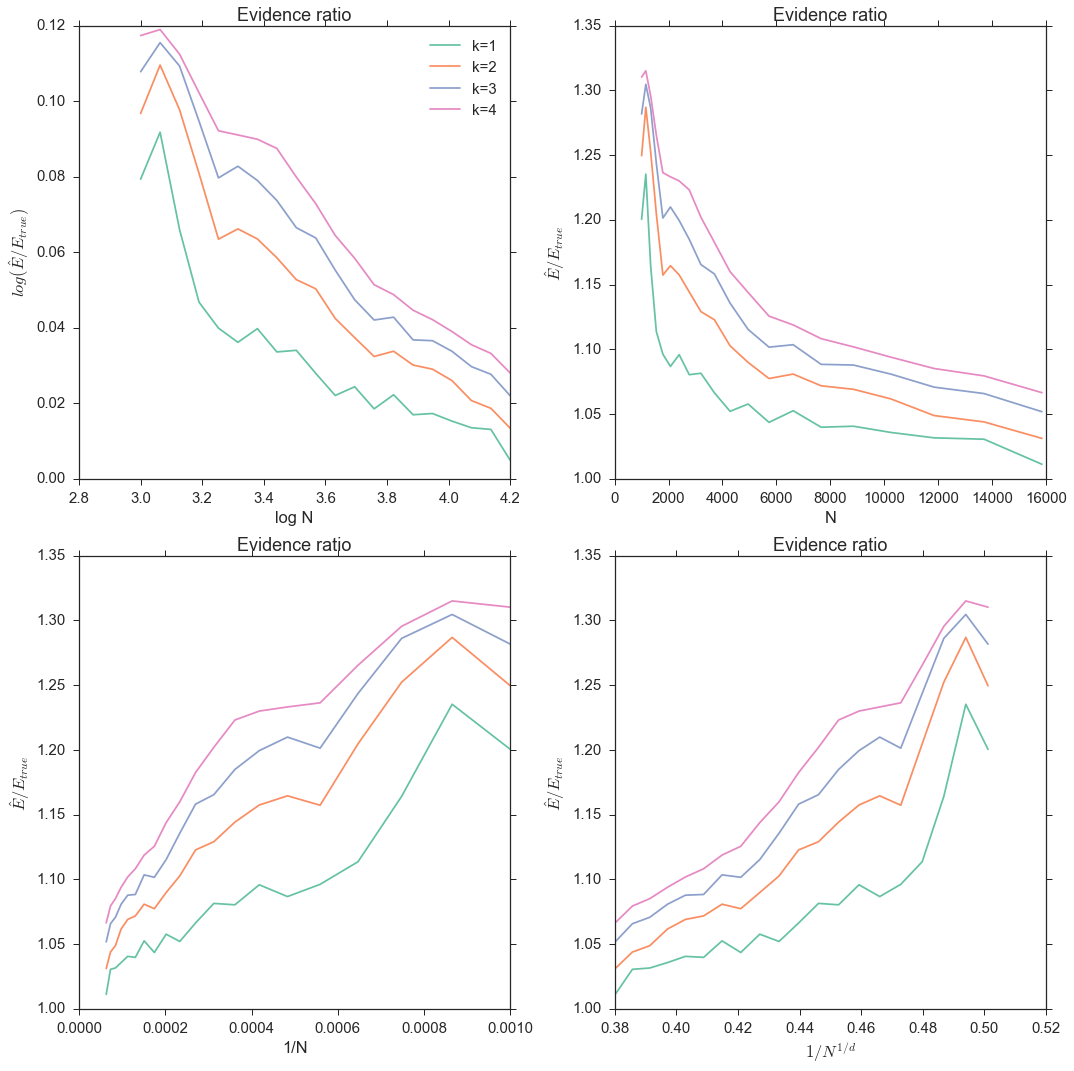

In [29]:
ealan.vis_mle(MLE)

## Emcee 2D example

In [ ]:
#test model class .. visualise uniform sampling
m2d=eknn.model_2d()

#test emcee wrapper 
mec2d=make_emcee_chain(m2d,nwalkers=200)
chain2d,fs=mec2d.mcmc(nmcmc=500)


#let's trangle plot chain samples 
fig = corner.corner(chain2d, labels=["$m$", "$b$"], extents=[[-1.1, -0.8], [3.5, 5.]],
                      truths=m2d.p, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, labels_args={"fontsize": 40})
fig.set_size_inches(10,10)

# Plot back the results in the space of data
#fig = plt.figure()
#xl = np.array([0, 10])
#for m, b in chain2d[np.random.randint(len(chain2d), size=100)]:
#    if m<0:
#        plt.plot(xl, m*xl+b, color="k", alpha=0.1)
    
#plt.plot(xl, m2d.p[0]*xl+m2d.p[1], color="r", lw=2, alpha=0.8)
#plt.errorbar(m2d.x, m2d.y, yerr=m2d.yerr, fmt=".k")
#plt.title('Input Data vs Samples (grey)')
#fig.set_size_inches(12, 8)

In [21]:
os.path.join

Help on function makedirs in module os:

makedirs(name, mode=511)
    makedirs(path [, mode=0777])
    
    Super-mkdir; create a leaf directory and all intermediate ones.
    Works like mkdir, except that any intermediate path segment (not
    just the rightmost) will be created if it does not exist.  This is
    recursive.

